In [9]:
import os
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.font_manager as fm
import seaborn as sns
sns.set()

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
os.makedirs("additional_plots", exist_ok=True)

In [11]:
def gauss_pdf(x, mu, sigma, amplitude=1):
    return amplitude / np.sqrt(2 * np.pi) / sigma * np.exp( -0.5 * np.mean((x - mu)**2, axis=1) / sigma**2)

In [12]:
lr = 1e-3
hidden_size = 128
weight_decay = 1e-2
batch_size = 32
iterations = 500

In [13]:
def predict(X, y, X_test):
    net = nn.Sequential(nn.Linear(2, hidden_size),
                        nn.ELU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ELU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ELU(),
                        nn.Linear(hidden_size, torch.max(y).cpu().item() + 1))

    opt = optim.Adam(params=net.parameters(), lr=lr, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()

    for _ in range(iterations):
        pred = net.forward(X)

        loss = ce(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

    with torch.no_grad():
        return torch.softmax(net.forward(X_test), dim=1).numpy()

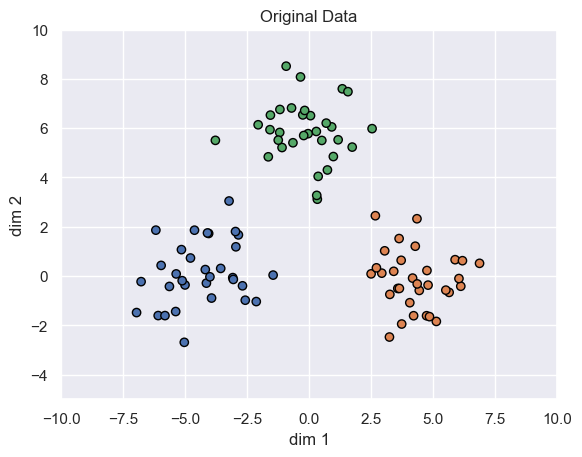

In [14]:
# dataset
n_samples = 32

location = 4
std = 1.2

rng = np.random.default_rng(seed=8)

x_train_1 = rng.normal((-location, 0), (std, std), (n_samples, 2))
y_train_1 = np.zeros_like(x_train_1[..., 0])
x_train_2 = rng.normal((location, 0), (std, std), (n_samples, 2))
y_train_2 = np.ones_like(x_train_2[..., 0])
x_train_3 = rng.normal((0, location * np.sqrt(2)), (std, std), (n_samples, 2))
y_train_3 = np.ones_like(x_train_3[..., 0]) * 2

X = np.concatenate((x_train_1, x_train_2, x_train_3))
y = np.concatenate((y_train_1, y_train_2, y_train_3)).astype(np.int32)

newpoint = torch.ones((1, 2)) * 8
newpoint[0, 0] = -8

n_classes = 2

x_labels= ["dim 1", "dim 2"]

num_mesh = 200
X_test = np.asarray(np.meshgrid(np.linspace(-10, 10, num_mesh),
                                np.linspace(-5, 10, num_mesh)))
X_test = np.moveaxis(X_test, 0, -1)
X_test = X_test.reshape(-1, 2)

plt.title("Original Data")
plt.scatter(X[:, 0], X[:, 1], c=[f"C{_y}" for _y in y], edgecolors="black")
plt.xlabel(x_labels[0])
plt.ylabel(x_labels[1])
plt.xlim(np.min(X_test[:, 0]), np.max(X_test[:, 0]))
plt.ylim(np.min(X_test[:, 1]), np.max(X_test[:, 1]))
plt.show()


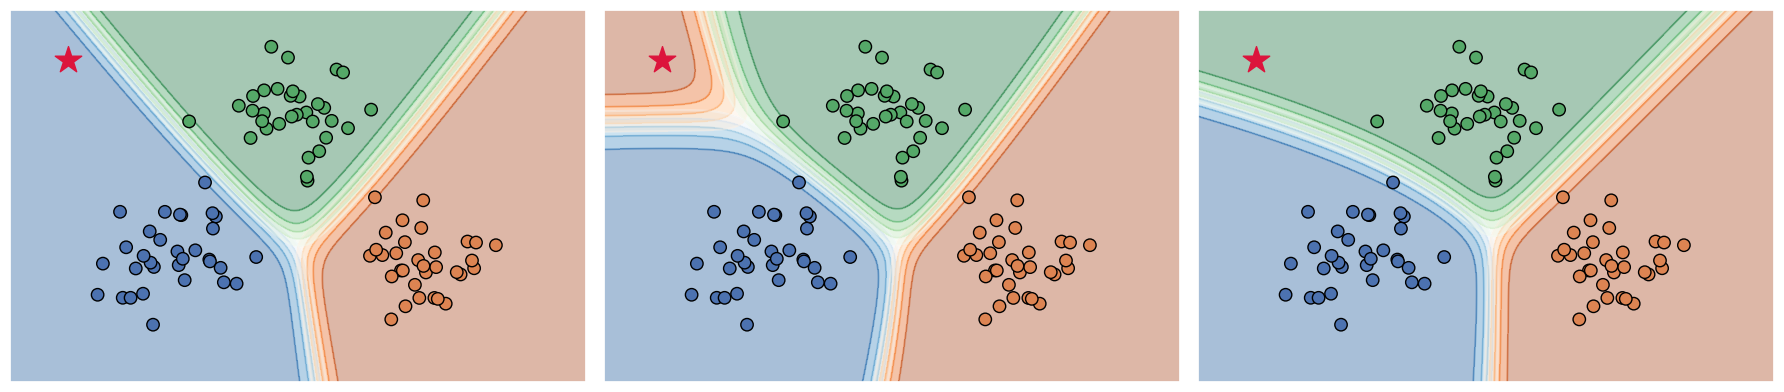

In [15]:
X = torch.as_tensor(X).to(dtype=torch.float32)
y = torch.as_tensor(y).to(dtype=torch.long)
newpoint = torch.as_tensor(newpoint).to(dtype=torch.float32)
X_test = torch.as_tensor(X_test).to(dtype=torch.float32)

torch.manual_seed(42)

alpha=0.35
num_linspace = 6
num_repeats = 5

fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for i in range(3):
    pred = predict(torch.cat((X, newpoint[[0]].repeat(num_repeats, 1)), dim=0), 
                torch.cat((y, torch.ones((num_repeats,), dtype=torch.long) * i), dim=0), X_test)
    for j, cmap in enumerate(["Blues", "Oranges", "Greens"]):
        axs[i].contourf(X_test[:, 0].reshape(num_mesh, num_mesh), X_test[:, 1].reshape(num_mesh, num_mesh),
                                pred[:, j].reshape(num_mesh, num_mesh), cmap=cmap, alpha=alpha,
                                levels=np.linspace(0.33, 1, num_linspace))
        axs[i].contour(X_test[:, 0].reshape(num_mesh, num_mesh), X_test[:, 1].reshape(num_mesh, num_mesh),
                                pred[:, j].reshape(num_mesh, num_mesh), cmap=cmap, alpha=alpha,
                                levels=np.linspace(0.33, 1, num_linspace))
    axs[i].scatter(X[:, 0], X[:, 1], s=80, c=[f"C{_y}" for _y in y], edgecolors="black", zorder=99)
    axs[i].scatter(newpoint[0, 0], newpoint[0, 1], marker="*", c="crimson", s=400, edgecolors="crimson", linewidths=1, zorder=99)
    axs[i].set_facecolor("white")

fig.tight_layout()
#plt.ylim(bottom=-4, top=4)
#plt.xlim(left=-4, right=4)
plt.xticks([])
plt.yticks([])
plt.tight_layout(rect=[-0.01, -0.01, 1.01, 1.01])
plt.savefig(os.path.join("additional_plots", "adversarial_models_neurips.png"))
plt.show()